**IMPORT LIBRARIES**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

**ULTIS**


In [3]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/kaggle/input/datasolar/Data_Solar_cut.csv',header=0)
    df.set_index('DATE (MM/DD/YYYY)', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
    num_columns = len(corr_matrix.columns)
    for i in range(num_columns):
        if i != 0:
            if abs(corr_matrix.iloc[i,25 ]) < threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data


In [4]:
df = concat_csv()
print(df.info())  # Kiểm tra kiểu dữ liệu

/tmp/ipykernel_35/1664809209.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 26 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Azimuth Angle [degrees]                 float64
 2   Airmass                                 float64
 3   Tower Dry Bulb Temp [deg C]             float64
 4   Tower Wet Bulb Temp [deg C]             float64
 5   Tower Dew Point Temp [deg C]            float64
 6   Tower Wind Chill Temp [deg C]           float64
 7   Tower RH [%]                            float64
 8   Total Cloud Cover [%]                   int64  
 9   Opaque Cloud Cover [%]                  int64  
 10  Avg Wind Speed @ 19ft [m/s]             float64
 11  Peak Wind Speed @ 19ft [m/s]            float64
 12  Avg Wind Direction @ 19ft [deg from N]  float64
 13  Vertical Wind Shear [1/s]               float64
 14  Station P

**MODEL**

In [5]:

device = "cuda" if torch.cuda.is_available() else "cpu"

class GRU(nn.Module):
    def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
        super(GRU,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size*seq_length,seq_length)
    def forward(self,x):
        out,_ = self.lstm(x)
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = out.reshape(out.shape[0],-1)
        # out: tensor of shape (batch_size, seq_length * hidden_size)

        out = self.fc(out)
        # out: shape (batch_size,seq_length)
        return out


**DATASET**

In [6]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]



        return torch.tensor(features),torch.tensor(targets)

In [7]:
df = df.iloc[:, [0, 2, 3, 7, 9, 12, 23, 25]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 8 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Airmass                                 float64
 2   Tower Dry Bulb Temp [deg C]             float64
 3   Tower RH [%]                            float64
 4   Opaque Cloud Cover [%]                  int64  
 5   Avg Wind Direction @ 19ft [deg from N]  float64
 6   Global Extraterrestrial (calc) [W/m^2]  float64
 7   GHI Mean                                float64
dtypes: float64(7), int64(1)
memory usage: 119.6+ MB
None


In [8]:
target_column = 'GHI Mean'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [9]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [10]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)


The shape of the original data: (1742341, 8)
The shape of the train data: (1393872, 8)
The shape of the train target: (1393872, 1)
The shape of the val data: (174234, 8)
The shape of the val target: (174234, 1)
The shape of the test data: (174235, 8)
The shape of the test target: (174235, 1)
58077
7258
7258


**TRAIN**

In [11]:
#HYPERPARAMETERS
input_size = 8
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.01
batch_size = 16
num_epochs = 300
min_valid_loss = np.inf

In [12]:
# MODEL
model = GRU(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [13]:
#LOSS AND OPTIMIZER
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [14]:
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    print("Train Loss:",train_loss / len(train_data_loader))
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    print("Validation Loss:", valid_loss/len(val_data_loader))

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "model_predict_.pth.tar")


Epoch:  0


100%|██████████| 3630/3630 [00:11<00:00, 318.02it/s]


Train Loss: 0.18196966527838043


100%|██████████| 454/454 [00:00<00:00, 1049.11it/s]


Validation Loss: 0.13659011241918356
Validation Loss Decreased(inf--->0.136590 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 3630/3630 [00:10<00:00, 334.54it/s]


Train Loss: 0.13420472129167266


100%|██████████| 454/454 [00:00<00:00, 1044.39it/s]


Validation Loss: 0.09587101321482809
Validation Loss Decreased(0.136590--->0.095871 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 3630/3630 [00:10<00:00, 331.63it/s]


Train Loss: 0.12416596567077362


100%|██████████| 454/454 [00:00<00:00, 1053.95it/s]


Validation Loss: 0.10560711436712138
Epoch:  3


100%|██████████| 3630/3630 [00:10<00:00, 337.34it/s]


Train Loss: 0.11402521246996741


100%|██████████| 454/454 [00:00<00:00, 921.66it/s]


Validation Loss: 0.0755693131574688
Validation Loss Decreased(0.095871--->0.075569 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 3630/3630 [00:11<00:00, 321.96it/s]


Train Loss: 0.1043523204936383


100%|██████████| 454/454 [00:00<00:00, 1066.05it/s]


Validation Loss: 0.06399229991081527
Validation Loss Decreased(0.075569--->0.063992 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 3630/3630 [00:10<00:00, 334.73it/s]


Train Loss: 0.09832250473752811


100%|██████████| 454/454 [00:00<00:00, 1065.82it/s]


Validation Loss: 0.05918024606877217
Validation Loss Decreased(0.063992--->0.059180 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 3630/3630 [00:10<00:00, 336.53it/s]


Train Loss: 0.09743038891581257


100%|██████████| 454/454 [00:00<00:00, 1037.21it/s]


Validation Loss: 0.05886614701576277
Validation Loss Decreased(0.059180--->0.058866 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 3630/3630 [00:10<00:00, 331.19it/s]


Train Loss: 0.09709347929485335


100%|██████████| 454/454 [00:00<00:00, 1031.81it/s]


Validation Loss: 0.05873172940852827
Validation Loss Decreased(0.058866--->0.058732 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 3630/3630 [00:10<00:00, 335.67it/s]


Train Loss: 0.09685197972103898


100%|██████████| 454/454 [00:00<00:00, 1025.48it/s]


Validation Loss: 0.058628153101164676
Validation Loss Decreased(0.058732--->0.058628 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 3630/3630 [00:10<00:00, 334.57it/s]


Train Loss: 0.09664609596399336


100%|██████████| 454/454 [00:00<00:00, 1079.03it/s]


Validation Loss: 0.058497986271917164
Validation Loss Decreased(0.058628--->0.058498 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 3630/3630 [00:10<00:00, 332.88it/s]


Train Loss: 0.09646555153418832


100%|██████████| 454/454 [00:00<00:00, 1055.30it/s]


Validation Loss: 0.05835170981006316
Validation Loss Decreased(0.058498--->0.058352 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 3630/3630 [00:10<00:00, 336.83it/s]


Train Loss: 0.09630648094940279


100%|██████████| 454/454 [00:00<00:00, 1056.97it/s]


Validation Loss: 0.05822378903692655
Validation Loss Decreased(0.058352--->0.058224 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 3630/3630 [00:10<00:00, 335.10it/s]


Train Loss: 0.09615240708897209


100%|██████████| 454/454 [00:00<00:00, 1032.46it/s]


Validation Loss: 0.05812133654604214
Validation Loss Decreased(0.058224--->0.058121 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 3630/3630 [00:10<00:00, 332.63it/s]


Train Loss: 0.09601866014054995


100%|██████████| 454/454 [00:00<00:00, 1048.61it/s]


Validation Loss: 0.05803806475435598
Validation Loss Decreased(0.058121--->0.058038 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 3630/3630 [00:10<00:00, 333.04it/s]


Train Loss: 0.0958939360326337


100%|██████████| 454/454 [00:00<00:00, 1002.00it/s]


Validation Loss: 0.05795642531214147
Validation Loss Decreased(0.058038--->0.057956 	 Saving The Model
=> Saving checkpoint
Epoch:  15


100%|██████████| 3630/3630 [00:11<00:00, 327.24it/s]


Train Loss: 0.09577175435189512


100%|██████████| 454/454 [00:00<00:00, 1006.15it/s]


Validation Loss: 0.057890205749460306
Validation Loss Decreased(0.057956--->0.057890 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 3630/3630 [00:11<00:00, 323.12it/s]


Train Loss: 0.0956646518505816


100%|██████████| 454/454 [00:00<00:00, 994.19it/s]


Validation Loss: 0.05780020280735899
Validation Loss Decreased(0.057890--->0.057800 	 Saving The Model
=> Saving checkpoint
Epoch:  17


100%|██████████| 3630/3630 [00:11<00:00, 314.42it/s]


Train Loss: 0.09557702303299824


100%|██████████| 454/454 [00:00<00:00, 940.71it/s]


Validation Loss: 0.057730464808556196
Validation Loss Decreased(0.057800--->0.057730 	 Saving The Model
=> Saving checkpoint
Epoch:  18


100%|██████████| 3630/3630 [00:11<00:00, 312.72it/s]


Train Loss: 0.09547573674940457


100%|██████████| 454/454 [00:00<00:00, 958.67it/s]


Validation Loss: 0.0576927365710108
Validation Loss Decreased(0.057730--->0.057693 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 3630/3630 [00:11<00:00, 321.29it/s]


Train Loss: 0.09537985663577896


100%|██████████| 454/454 [00:00<00:00, 964.23it/s] 


Validation Loss: 0.057658893742141136
Validation Loss Decreased(0.057693--->0.057659 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 3630/3630 [00:11<00:00, 324.27it/s]


Train Loss: 0.09529172462631628


100%|██████████| 454/454 [00:00<00:00, 1011.41it/s]


Validation Loss: 0.0575812582164351
Validation Loss Decreased(0.057659--->0.057581 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 3630/3630 [00:11<00:00, 315.84it/s]


Train Loss: 0.09519771964252928


100%|██████████| 454/454 [00:00<00:00, 992.17it/s]


Validation Loss: 0.05752403271493965
Validation Loss Decreased(0.057581--->0.057524 	 Saving The Model
=> Saving checkpoint
Epoch:  22


100%|██████████| 3630/3630 [00:11<00:00, 320.80it/s]


Train Loss: 0.09511232136341498


100%|██████████| 454/454 [00:00<00:00, 1003.33it/s]


Validation Loss: 0.05745994143693086
Validation Loss Decreased(0.057524--->0.057460 	 Saving The Model
=> Saving checkpoint
Epoch:  23


100%|██████████| 3630/3630 [00:11<00:00, 323.37it/s]


Train Loss: 0.09503163809549081


100%|██████████| 454/454 [00:00<00:00, 929.59it/s]


Validation Loss: 0.057405158846506016
Validation Loss Decreased(0.057460--->0.057405 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 3630/3630 [00:11<00:00, 326.85it/s]


Train Loss: 0.09494945544943684


100%|██████████| 454/454 [00:00<00:00, 1012.58it/s]


Validation Loss: 0.05736626592339547
Validation Loss Decreased(0.057405--->0.057366 	 Saving The Model
=> Saving checkpoint
Epoch:  25


100%|██████████| 3630/3630 [00:11<00:00, 322.46it/s]


Train Loss: 0.09486123957526027


100%|██████████| 454/454 [00:00<00:00, 990.85it/s] 


Validation Loss: 0.05731953239560205
Validation Loss Decreased(0.057366--->0.057320 	 Saving The Model
=> Saving checkpoint
Epoch:  26


100%|██████████| 3630/3630 [00:11<00:00, 315.69it/s]


Train Loss: 0.09479000532265465


100%|██████████| 454/454 [00:00<00:00, 984.01it/s]


Validation Loss: 0.057280839080070985
Validation Loss Decreased(0.057320--->0.057281 	 Saving The Model
=> Saving checkpoint
Epoch:  27


100%|██████████| 3630/3630 [00:11<00:00, 321.35it/s]


Train Loss: 0.09471233817999275


100%|██████████| 454/454 [00:00<00:00, 983.12it/s]


Validation Loss: 0.05726832668406613
Validation Loss Decreased(0.057281--->0.057268 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 3630/3630 [00:11<00:00, 324.96it/s]


Train Loss: 0.09464920711704079


100%|██████████| 454/454 [00:00<00:00, 994.60it/s] 


Validation Loss: 0.057182608615553944
Validation Loss Decreased(0.057268--->0.057183 	 Saving The Model
=> Saving checkpoint
Epoch:  29


100%|██████████| 3630/3630 [00:11<00:00, 319.87it/s]


Train Loss: 0.09457033116127266


100%|██████████| 454/454 [00:00<00:00, 1005.89it/s]


Validation Loss: 0.05718742652925958
Epoch:  30


100%|██████████| 3630/3630 [00:11<00:00, 328.73it/s]


Train Loss: 0.09449895234536011


100%|██████████| 454/454 [00:00<00:00, 1038.90it/s]


Validation Loss: 0.0571003576427564
Validation Loss Decreased(0.057183--->0.057100 	 Saving The Model
=> Saving checkpoint
Epoch:  31


100%|██████████| 3630/3630 [00:10<00:00, 330.68it/s]


Train Loss: 0.09443384585663972


100%|██████████| 454/454 [00:00<00:00, 1023.16it/s]


Validation Loss: 0.057039590172288455
Validation Loss Decreased(0.057100--->0.057040 	 Saving The Model
=> Saving checkpoint
Epoch:  32


100%|██████████| 3630/3630 [00:11<00:00, 323.34it/s]


Train Loss: 0.09436233484977127


100%|██████████| 454/454 [00:00<00:00, 1009.50it/s]


Validation Loss: 0.0570562746804055
Epoch:  33


100%|██████████| 3630/3630 [00:11<00:00, 328.39it/s]


Train Loss: 0.0942857513231627


100%|██████████| 454/454 [00:00<00:00, 1018.57it/s]


Validation Loss: 0.05700247522165251
Validation Loss Decreased(0.057040--->0.057002 	 Saving The Model
=> Saving checkpoint
Epoch:  34


100%|██████████| 3630/3630 [00:11<00:00, 328.37it/s]


Train Loss: 0.09422790823865641


100%|██████████| 454/454 [00:00<00:00, 934.09it/s]


Validation Loss: 0.057014258171607116
Epoch:  35


100%|██████████| 3630/3630 [00:11<00:00, 327.24it/s]


Train Loss: 0.09416542475744831


100%|██████████| 454/454 [00:00<00:00, 978.45it/s]


Validation Loss: 0.05704034737252711
Epoch:  36


100%|██████████| 3630/3630 [00:10<00:00, 330.07it/s]


Train Loss: 0.09411055860341536


100%|██████████| 454/454 [00:00<00:00, 1010.89it/s]


Validation Loss: 0.056991734612340285
Validation Loss Decreased(0.057002--->0.056992 	 Saving The Model
=> Saving checkpoint
Epoch:  37


100%|██████████| 3630/3630 [00:11<00:00, 321.94it/s]


Train Loss: 0.09404434127704829


100%|██████████| 454/454 [00:00<00:00, 1001.63it/s]


Validation Loss: 0.056916287234472264
Validation Loss Decreased(0.056992--->0.056916 	 Saving The Model
=> Saving checkpoint
Epoch:  38


100%|██████████| 3630/3630 [00:11<00:00, 322.74it/s]


Train Loss: 0.0939855981166766


100%|██████████| 454/454 [00:00<00:00, 994.18it/s] 


Validation Loss: 0.05692901574196381
Epoch:  39


100%|██████████| 3630/3630 [00:11<00:00, 323.93it/s]


Train Loss: 0.09391735051524273


100%|██████████| 454/454 [00:00<00:00, 1006.19it/s]


Validation Loss: 0.05687741826225964
Validation Loss Decreased(0.056916--->0.056877 	 Saving The Model
=> Saving checkpoint
Epoch:  40


100%|██████████| 3630/3630 [00:11<00:00, 321.17it/s]


Train Loss: 0.09387102550391412


100%|██████████| 454/454 [00:00<00:00, 1020.63it/s]


Validation Loss: 0.056842645258509523
Validation Loss Decreased(0.056877--->0.056843 	 Saving The Model
=> Saving checkpoint
Epoch:  41


100%|██████████| 3630/3630 [00:11<00:00, 321.34it/s]


Train Loss: 0.09380752519335311


100%|██████████| 454/454 [00:00<00:00, 987.86it/s]


Validation Loss: 0.05683829754441366
Validation Loss Decreased(0.056843--->0.056838 	 Saving The Model
=> Saving checkpoint
Epoch:  42


100%|██████████| 3630/3630 [00:11<00:00, 324.78it/s]


Train Loss: 0.09375152411385715


100%|██████████| 454/454 [00:00<00:00, 988.80it/s]


Validation Loss: 0.05689170834925249
Epoch:  43


100%|██████████| 3630/3630 [00:11<00:00, 318.90it/s]


Train Loss: 0.09369702414760844


100%|██████████| 454/454 [00:00<00:00, 1019.35it/s]


Validation Loss: 0.05688647412283306
Epoch:  44


100%|██████████| 3630/3630 [00:11<00:00, 327.00it/s]


Train Loss: 0.09364103848961587


100%|██████████| 454/454 [00:00<00:00, 985.01it/s] 


Validation Loss: 0.05682785310098488
Validation Loss Decreased(0.056838--->0.056828 	 Saving The Model
=> Saving checkpoint
Epoch:  45


100%|██████████| 3630/3630 [00:11<00:00, 323.41it/s]


Train Loss: 0.0935963570856954


100%|██████████| 454/454 [00:00<00:00, 979.86it/s]


Validation Loss: 0.056833845521308
Epoch:  46


100%|██████████| 3630/3630 [00:11<00:00, 323.95it/s]


Train Loss: 0.09353088605975278


100%|██████████| 454/454 [00:00<00:00, 986.27it/s]


Validation Loss: 0.05682334161381748
Validation Loss Decreased(0.056828--->0.056823 	 Saving The Model
=> Saving checkpoint
Epoch:  47


100%|██████████| 3630/3630 [00:11<00:00, 326.17it/s]


Train Loss: 0.09349056676165617


100%|██████████| 454/454 [00:00<00:00, 995.92it/s] 


Validation Loss: 0.05675236119113112
Validation Loss Decreased(0.056823--->0.056752 	 Saving The Model
=> Saving checkpoint
Epoch:  48


100%|██████████| 3630/3630 [00:11<00:00, 316.79it/s]


Train Loss: 0.09343346821619225


100%|██████████| 454/454 [00:00<00:00, 987.86it/s]


Validation Loss: 0.05676166914836278
Epoch:  49


100%|██████████| 3630/3630 [00:11<00:00, 324.19it/s]


Train Loss: 0.09338459124591189


100%|██████████| 454/454 [00:00<00:00, 991.94it/s] 


Validation Loss: 0.0567477773203174
Validation Loss Decreased(0.056752--->0.056748 	 Saving The Model
=> Saving checkpoint
Epoch:  50


100%|██████████| 3630/3630 [00:11<00:00, 320.53it/s]


Train Loss: 0.0933314029418518


100%|██████████| 454/454 [00:00<00:00, 1000.87it/s]


Validation Loss: 0.056667622623876424
Validation Loss Decreased(0.056748--->0.056668 	 Saving The Model
=> Saving checkpoint
Epoch:  51


100%|██████████| 3630/3630 [00:11<00:00, 320.74it/s]


Train Loss: 0.0932876088861174


100%|██████████| 454/454 [00:00<00:00, 1009.49it/s]


Validation Loss: 0.05673259149527904
Epoch:  52


100%|██████████| 3630/3630 [00:11<00:00, 318.27it/s]


Train Loss: 0.09322981114681911


100%|██████████| 454/454 [00:00<00:00, 887.27it/s]


Validation Loss: 0.05668788184899345
Epoch:  53


100%|██████████| 3630/3630 [00:11<00:00, 325.82it/s]


Train Loss: 0.09318625266675576


100%|██████████| 454/454 [00:00<00:00, 1013.40it/s]


Validation Loss: 0.056664877979741034
Validation Loss Decreased(0.056668--->0.056665 	 Saving The Model
=> Saving checkpoint
Epoch:  54


100%|██████████| 3630/3630 [00:11<00:00, 325.52it/s]


Train Loss: 0.09313286510884056


100%|██████████| 454/454 [00:00<00:00, 1001.84it/s]


Validation Loss: 0.056637751709000955
Validation Loss Decreased(0.056665--->0.056638 	 Saving The Model
=> Saving checkpoint
Epoch:  55


100%|██████████| 3630/3630 [00:11<00:00, 329.01it/s]


Train Loss: 0.09308773095661048


100%|██████████| 454/454 [00:00<00:00, 1008.70it/s]


Validation Loss: 0.05660334463083631
Validation Loss Decreased(0.056638--->0.056603 	 Saving The Model
=> Saving checkpoint
Epoch:  56


100%|██████████| 3630/3630 [00:11<00:00, 321.67it/s]


Train Loss: 0.09302974088109182


100%|██████████| 454/454 [00:00<00:00, 1013.49it/s]


Validation Loss: 0.05660852084368981
Epoch:  57


100%|██████████| 3630/3630 [00:11<00:00, 321.06it/s]


Train Loss: 0.09298294914768837


100%|██████████| 454/454 [00:00<00:00, 1000.91it/s]


Validation Loss: 0.056574549664139245
Validation Loss Decreased(0.056603--->0.056575 	 Saving The Model
=> Saving checkpoint
Epoch:  58


100%|██████████| 3630/3630 [00:11<00:00, 322.14it/s]


Train Loss: 0.09292725137215298


100%|██████████| 454/454 [00:00<00:00, 937.40it/s] 


Validation Loss: 0.05659194903068464
Epoch:  59


100%|██████████| 3630/3630 [00:11<00:00, 324.01it/s]


Train Loss: 0.09288287257098218


100%|██████████| 454/454 [00:00<00:00, 1023.20it/s]


Validation Loss: 0.05652883101137004
Validation Loss Decreased(0.056575--->0.056529 	 Saving The Model
=> Saving checkpoint
Epoch:  60


100%|██████████| 3630/3630 [00:11<00:00, 329.44it/s]


Train Loss: 0.09283026098849657


100%|██████████| 454/454 [00:00<00:00, 1000.17it/s]


Validation Loss: 0.05649103567891806
Validation Loss Decreased(0.056529--->0.056491 	 Saving The Model
=> Saving checkpoint
Epoch:  61


100%|██████████| 3630/3630 [00:11<00:00, 328.34it/s]


Train Loss: 0.09278325564483358


100%|██████████| 454/454 [00:00<00:00, 1015.14it/s]


Validation Loss: 0.05647087675372615
Validation Loss Decreased(0.056491--->0.056471 	 Saving The Model
=> Saving checkpoint
Epoch:  62


100%|██████████| 3630/3630 [00:11<00:00, 325.99it/s]


Train Loss: 0.09274647319981033


100%|██████████| 454/454 [00:00<00:00, 1025.81it/s]


Validation Loss: 0.056425897034102696
Validation Loss Decreased(0.056471--->0.056426 	 Saving The Model
=> Saving checkpoint
Epoch:  63


100%|██████████| 3630/3630 [00:11<00:00, 328.90it/s]


Train Loss: 0.09269539647097336


100%|██████████| 454/454 [00:00<00:00, 1020.54it/s]


Validation Loss: 0.05644365767438051
Epoch:  64


100%|██████████| 3630/3630 [00:10<00:00, 331.76it/s]


Train Loss: 0.09264546731819767


100%|██████████| 454/454 [00:00<00:00, 1007.16it/s]


Validation Loss: 0.05648186219580682
Epoch:  65


100%|██████████| 3630/3630 [00:11<00:00, 326.80it/s]


Train Loss: 0.0926007465778386


100%|██████████| 454/454 [00:00<00:00, 1021.10it/s]


Validation Loss: 0.05652409752064868
Epoch:  66


100%|██████████| 3630/3630 [00:10<00:00, 331.76it/s]


Train Loss: 0.09254844475051131


100%|██████████| 454/454 [00:00<00:00, 997.11it/s]


Validation Loss: 0.056431694800539445
Epoch:  67


100%|██████████| 3630/3630 [00:11<00:00, 328.10it/s]


Train Loss: 0.09249514193959804


100%|██████████| 454/454 [00:00<00:00, 1002.95it/s]


Validation Loss: 0.05640326415430993
Validation Loss Decreased(0.056426--->0.056403 	 Saving The Model
=> Saving checkpoint
Epoch:  68


100%|██████████| 3630/3630 [00:10<00:00, 330.04it/s]


Train Loss: 0.09246452325326074


100%|██████████| 454/454 [00:00<00:00, 996.59it/s] 


Validation Loss: 0.05637877239063736
Validation Loss Decreased(0.056403--->0.056379 	 Saving The Model
=> Saving checkpoint
Epoch:  69


100%|██████████| 3630/3630 [00:11<00:00, 329.77it/s]


Train Loss: 0.09241507935059251


100%|██████████| 454/454 [00:00<00:00, 1018.11it/s]


Validation Loss: 0.056442671156936325
Epoch:  70


100%|██████████| 3630/3630 [00:11<00:00, 324.46it/s]


Train Loss: 0.09236773728049384


100%|██████████| 454/454 [00:00<00:00, 1020.99it/s]


Validation Loss: 0.05646063633476774
Epoch:  71


100%|██████████| 3630/3630 [00:10<00:00, 331.05it/s]


Train Loss: 0.09232255464612886


100%|██████████| 454/454 [00:00<00:00, 1030.53it/s]


Validation Loss: 0.05636782132973215
Validation Loss Decreased(0.056379--->0.056368 	 Saving The Model
=> Saving checkpoint
Epoch:  72


100%|██████████| 3630/3630 [00:10<00:00, 331.20it/s]


Train Loss: 0.09229284168700748


100%|██████████| 454/454 [00:00<00:00, 1020.90it/s]


Validation Loss: 0.056379939424205314
Epoch:  73


100%|██████████| 3630/3630 [00:11<00:00, 326.99it/s]


Train Loss: 0.09224616577782947


100%|██████████| 454/454 [00:00<00:00, 1009.96it/s]


Validation Loss: 0.05636359048115399
Validation Loss Decreased(0.056368--->0.056364 	 Saving The Model
=> Saving checkpoint
Epoch:  74


100%|██████████| 3630/3630 [00:11<00:00, 326.75it/s]


Train Loss: 0.09219512913422835


100%|██████████| 454/454 [00:00<00:00, 1027.06it/s]


Validation Loss: 0.05635255785266118
Validation Loss Decreased(0.056364--->0.056353 	 Saving The Model
=> Saving checkpoint
Epoch:  75


100%|██████████| 3630/3630 [00:11<00:00, 329.84it/s]


Train Loss: 0.09217341394790263


100%|██████████| 454/454 [00:00<00:00, 1016.87it/s]


Validation Loss: 0.05632708706134148
Validation Loss Decreased(0.056353--->0.056327 	 Saving The Model
=> Saving checkpoint
Epoch:  76


100%|██████████| 3630/3630 [00:11<00:00, 323.27it/s]


Train Loss: 0.0921153417630239


100%|██████████| 454/454 [00:00<00:00, 1017.88it/s]


Validation Loss: 0.05632595257526343
Validation Loss Decreased(0.056327--->0.056326 	 Saving The Model
=> Saving checkpoint
Epoch:  77


100%|██████████| 3630/3630 [00:11<00:00, 329.81it/s]


Train Loss: 0.09205549067875395


100%|██████████| 454/454 [00:00<00:00, 1037.02it/s]


Validation Loss: 0.05633540554803571
Epoch:  78


100%|██████████| 3630/3630 [00:11<00:00, 329.30it/s]


Train Loss: 0.0920284226187595


100%|██████████| 454/454 [00:00<00:00, 869.44it/s]


Validation Loss: 0.05624434864691791
Validation Loss Decreased(0.056326--->0.056244 	 Saving The Model
=> Saving checkpoint
Epoch:  79


100%|██████████| 3630/3630 [00:11<00:00, 319.75it/s]


Train Loss: 0.09197897616405315


100%|██████████| 454/454 [00:00<00:00, 977.30it/s]


Validation Loss: 0.05629890412742878
Epoch:  80


100%|██████████| 3630/3630 [00:11<00:00, 328.92it/s]


Train Loss: 0.09194259509050093


100%|██████████| 454/454 [00:00<00:00, 1019.32it/s]


Validation Loss: 0.056344510604275366
Epoch:  81


100%|██████████| 3630/3630 [00:11<00:00, 325.09it/s]


Train Loss: 0.09191162550197872


100%|██████████| 454/454 [00:00<00:00, 989.97it/s] 


Validation Loss: 0.056282341955067455
Epoch:  82


100%|██████████| 3630/3630 [00:10<00:00, 330.11it/s]


Train Loss: 0.09185292307320046


100%|██████████| 454/454 [00:00<00:00, 1021.90it/s]


Validation Loss: 0.056203956001148185
Validation Loss Decreased(0.056244--->0.056204 	 Saving The Model
=> Saving checkpoint
Epoch:  83


100%|██████████| 3630/3630 [00:11<00:00, 329.81it/s]


Train Loss: 0.09182059540561124


100%|██████████| 454/454 [00:00<00:00, 1007.00it/s]


Validation Loss: 0.056192116904631974
Validation Loss Decreased(0.056204--->0.056192 	 Saving The Model
=> Saving checkpoint
Epoch:  84


100%|██████████| 3630/3630 [00:11<00:00, 324.55it/s]


Train Loss: 0.09177901439214327


100%|██████████| 454/454 [00:00<00:00, 952.42it/s]


Validation Loss: 0.05625559782922434
Epoch:  85


100%|██████████| 3630/3630 [00:11<00:00, 328.86it/s]


Train Loss: 0.09172886848604367


100%|██████████| 454/454 [00:00<00:00, 1015.72it/s]


Validation Loss: 0.0561403343946653
Validation Loss Decreased(0.056192--->0.056140 	 Saving The Model
=> Saving checkpoint
Epoch:  86


100%|██████████| 3630/3630 [00:11<00:00, 328.95it/s]


Train Loss: 0.09168334801062543


100%|██████████| 454/454 [00:00<00:00, 995.80it/s] 


Validation Loss: 0.056234905663827085
Epoch:  87


100%|██████████| 3630/3630 [00:11<00:00, 327.12it/s]


Train Loss: 0.09164267635183612


100%|██████████| 454/454 [00:00<00:00, 1023.54it/s]


Validation Loss: 0.05617248159438684
Epoch:  88


100%|██████████| 3630/3630 [00:10<00:00, 331.47it/s]


Train Loss: 0.09159070697623724


100%|██████████| 454/454 [00:00<00:00, 1020.79it/s]


Validation Loss: 0.05623375060002674
Epoch:  89


100%|██████████| 3630/3630 [00:11<00:00, 329.28it/s]


Train Loss: 0.09156157788901743


100%|██████████| 454/454 [00:00<00:00, 1025.29it/s]


Validation Loss: 0.05633058553975176
Epoch:  90


100%|██████████| 3630/3630 [00:11<00:00, 328.28it/s]


Train Loss: 0.0915070289536247


100%|██████████| 454/454 [00:00<00:00, 1026.96it/s]


Validation Loss: 0.05622266459786541
Epoch:  91


100%|██████████| 3630/3630 [00:10<00:00, 332.90it/s]


Train Loss: 0.0914781495422955


100%|██████████| 454/454 [00:00<00:00, 965.02it/s] 


Validation Loss: 0.056209777234070744
Epoch:  92


100%|██████████| 3630/3630 [00:11<00:00, 325.55it/s]


Train Loss: 0.09143747014796963


100%|██████████| 454/454 [00:00<00:00, 1032.97it/s]


Validation Loss: 0.056129880126257733
Validation Loss Decreased(0.056140--->0.056130 	 Saving The Model
=> Saving checkpoint
Epoch:  93


100%|██████████| 3630/3630 [00:10<00:00, 331.06it/s]


Train Loss: 0.09140093978644134


100%|██████████| 454/454 [00:00<00:00, 1009.47it/s]


Validation Loss: 0.0562130490095399
Epoch:  94


100%|██████████| 3630/3630 [00:10<00:00, 335.59it/s]


Train Loss: 0.09135898308763811


100%|██████████| 454/454 [00:00<00:00, 1039.73it/s]


Validation Loss: 0.056254417959585044
Epoch:  95


100%|██████████| 3630/3630 [00:11<00:00, 325.74it/s]


Train Loss: 0.09132557146646228


100%|██████████| 454/454 [00:00<00:00, 1001.92it/s]


Validation Loss: 0.05613604129618303
Epoch:  96


100%|██████████| 3630/3630 [00:10<00:00, 332.07it/s]


Train Loss: 0.09128810355827072


100%|██████████| 454/454 [00:00<00:00, 1043.92it/s]


Validation Loss: 0.0561933932416418
Epoch:  97


100%|██████████| 3630/3630 [00:10<00:00, 331.22it/s]


Train Loss: 0.0912366045235474


100%|██████████| 454/454 [00:00<00:00, 1033.95it/s]


Validation Loss: 0.056167729248678404
Epoch:  98


100%|██████████| 3630/3630 [00:11<00:00, 323.74it/s]


Train Loss: 0.09121382454238298


100%|██████████| 454/454 [00:00<00:00, 1034.50it/s]


Validation Loss: 0.056149602809791796
Epoch:  99


100%|██████████| 3630/3630 [00:10<00:00, 331.51it/s]


Train Loss: 0.09118477327470682


100%|██████████| 454/454 [00:00<00:00, 1052.62it/s]


Validation Loss: 0.05620534993109518
Epoch:  100


100%|██████████| 3630/3630 [00:10<00:00, 330.36it/s]


Train Loss: 0.09113213306313296


100%|██████████| 454/454 [00:00<00:00, 1031.11it/s]


Validation Loss: 0.056133223658374774
Epoch:  101


100%|██████████| 3630/3630 [00:11<00:00, 328.33it/s]


Train Loss: 0.09109295801659735


100%|██████████| 454/454 [00:00<00:00, 980.01it/s] 


Validation Loss: 0.05616080517961263
Epoch:  102


100%|██████████| 3630/3630 [00:10<00:00, 331.99it/s]


Train Loss: 0.09104883146329702


100%|██████████| 454/454 [00:00<00:00, 1013.32it/s]


Validation Loss: 0.056174435759335554
Epoch:  103


100%|██████████| 3630/3630 [00:10<00:00, 331.01it/s]


Train Loss: 0.09103207784720017


100%|██████████| 454/454 [00:00<00:00, 1024.74it/s]


Validation Loss: 0.05621523530535823
Epoch:  104


100%|██████████| 3630/3630 [00:11<00:00, 328.82it/s]


Train Loss: 0.09099207261033897


100%|██████████| 454/454 [00:00<00:00, 1025.76it/s]


Validation Loss: 0.05625976995213828
Epoch:  105


100%|██████████| 3630/3630 [00:11<00:00, 326.06it/s]


Train Loss: 0.09094951141560059


100%|██████████| 454/454 [00:00<00:00, 1028.59it/s]


Validation Loss: 0.05619353597657037
Epoch:  106


100%|██████████| 3630/3630 [00:11<00:00, 321.80it/s]


Train Loss: 0.0909484563720895


100%|██████████| 454/454 [00:00<00:00, 1012.03it/s]


Validation Loss: 0.05625929357266025
Epoch:  107


100%|██████████| 3630/3630 [00:11<00:00, 326.75it/s]


Train Loss: 0.0908739504262094


100%|██████████| 454/454 [00:00<00:00, 1005.46it/s]


Validation Loss: 0.05623548521798672
Epoch:  108


100%|██████████| 3630/3630 [00:11<00:00, 329.01it/s]


Train Loss: 0.09084419747745585


100%|██████████| 454/454 [00:00<00:00, 992.75it/s] 


Validation Loss: 0.056118848148273996
Validation Loss Decreased(0.056130--->0.056119 	 Saving The Model
=> Saving checkpoint
Epoch:  109


100%|██████████| 3630/3630 [00:11<00:00, 327.12it/s]


Train Loss: 0.09078384350573225


100%|██████████| 454/454 [00:00<00:00, 1043.87it/s]


Validation Loss: 0.056366343210336685
Epoch:  110


100%|██████████| 3630/3630 [00:10<00:00, 333.08it/s]


Train Loss: 0.09078696656954692


100%|██████████| 454/454 [00:00<00:00, 1036.08it/s]


Validation Loss: 0.05622491565768762
Epoch:  111


100%|██████████| 3630/3630 [00:10<00:00, 333.41it/s]


Train Loss: 0.09073959657086433


100%|██████████| 454/454 [00:00<00:00, 1058.95it/s]


Validation Loss: 0.05629736467486782
Epoch:  112


100%|██████████| 3630/3630 [00:11<00:00, 322.78it/s]


Train Loss: 0.09070651905087249


100%|██████████| 454/454 [00:00<00:00, 1000.34it/s]


Validation Loss: 0.056320758823008944
Epoch:  113


100%|██████████| 3630/3630 [00:11<00:00, 315.21it/s]


Train Loss: 0.09066337084729963


100%|██████████| 454/454 [00:00<00:00, 965.53it/s]


Validation Loss: 0.05624075909090687
Epoch:  114


100%|██████████| 3630/3630 [00:11<00:00, 324.72it/s]


Train Loss: 0.09062464015841322


100%|██████████| 454/454 [00:00<00:00, 988.17it/s]


Validation Loss: 0.05628107457323895
Epoch:  115


100%|██████████| 3630/3630 [00:11<00:00, 321.10it/s]


Train Loss: 0.09059039000425971


100%|██████████| 454/454 [00:00<00:00, 935.28it/s]


Validation Loss: 0.05621404672615727
Epoch:  116


100%|██████████| 3630/3630 [00:11<00:00, 327.17it/s]


Train Loss: 0.09054442966422738


100%|██████████| 454/454 [00:00<00:00, 1030.66it/s]


Validation Loss: 0.05629221744708961
Epoch:  117


100%|██████████| 3630/3630 [00:11<00:00, 325.68it/s]


Train Loss: 0.09049797193322426


100%|██████████| 454/454 [00:00<00:00, 953.97it/s] 


Validation Loss: 0.05625280613632704
Epoch:  118


100%|██████████| 3630/3630 [00:11<00:00, 327.47it/s]


Train Loss: 0.09049884261634857


100%|██████████| 454/454 [00:00<00:00, 984.78it/s]


Validation Loss: 0.05635966003204092
Epoch:  119


100%|██████████| 3630/3630 [00:11<00:00, 325.69it/s]


Train Loss: 0.09044564512185002


100%|██████████| 454/454 [00:00<00:00, 1013.60it/s]


Validation Loss: 0.05630987763628189
Epoch:  120


100%|██████████| 3630/3630 [00:11<00:00, 322.71it/s]


Train Loss: 0.09042559504748417


100%|██████████| 454/454 [00:00<00:00, 1032.49it/s]


Validation Loss: 0.05631514698934192
Epoch:  121


100%|██████████| 3630/3630 [00:11<00:00, 328.40it/s]


Train Loss: 0.09038154307818431


100%|██████████| 454/454 [00:00<00:00, 1016.14it/s]


Validation Loss: 0.05642326771016135
Epoch:  122


100%|██████████| 3630/3630 [00:10<00:00, 333.66it/s]


Train Loss: 0.09032871503827576


100%|██████████| 454/454 [00:00<00:00, 1036.46it/s]


Validation Loss: 0.05630929854533152
Epoch:  123


100%|██████████| 3630/3630 [00:11<00:00, 328.39it/s]


Train Loss: 0.09032093427903677


100%|██████████| 454/454 [00:00<00:00, 996.85it/s] 


Validation Loss: 0.056327760430656876
Epoch:  124


100%|██████████| 3630/3630 [00:10<00:00, 332.98it/s]


Train Loss: 0.09029933428698086


100%|██████████| 454/454 [00:00<00:00, 1001.25it/s]


Validation Loss: 0.05644953268363334
Epoch:  125


100%|██████████| 3630/3630 [00:10<00:00, 332.27it/s]


Train Loss: 0.09023956337332292


100%|██████████| 454/454 [00:00<00:00, 1050.22it/s]


Validation Loss: 0.056445512284484606
Epoch:  126


100%|██████████| 3630/3630 [00:10<00:00, 332.29it/s]


Train Loss: 0.09022046598800759


100%|██████████| 454/454 [00:00<00:00, 1019.33it/s]


Validation Loss: 0.056399382660772504
Epoch:  127


100%|██████████| 3630/3630 [00:10<00:00, 331.95it/s]


Train Loss: 0.09018644448353906


100%|██████████| 454/454 [00:00<00:00, 1039.21it/s]


Validation Loss: 0.056509091099410054
Epoch:  128


100%|██████████| 3630/3630 [00:11<00:00, 328.45it/s]


Train Loss: 0.09013861602200077


100%|██████████| 454/454 [00:00<00:00, 1040.82it/s]


Validation Loss: 0.05649552854751893
Epoch:  129


100%|██████████| 3630/3630 [00:10<00:00, 336.78it/s]


Train Loss: 0.09011502410943219


100%|██████████| 454/454 [00:00<00:00, 1053.81it/s]


Validation Loss: 0.05653963285685637
Epoch:  130


100%|██████████| 3630/3630 [00:10<00:00, 334.51it/s]


Train Loss: 0.09008134614742623


100%|██████████| 454/454 [00:00<00:00, 1052.03it/s]


Validation Loss: 0.056558110831743995
Epoch:  131


100%|██████████| 3630/3630 [00:10<00:00, 331.40it/s]


Train Loss: 0.0900629043983268


100%|██████████| 454/454 [00:00<00:00, 979.29it/s] 


Validation Loss: 0.056531216418432145
Epoch:  132


100%|██████████| 3630/3630 [00:10<00:00, 334.51it/s]


Train Loss: 0.09002033211759865


100%|██████████| 454/454 [00:00<00:00, 1038.74it/s]


Validation Loss: 0.056531496694153034
Epoch:  133


100%|██████████| 3630/3630 [00:10<00:00, 333.48it/s]


Train Loss: 0.0899789753363142


100%|██████████| 454/454 [00:00<00:00, 1047.80it/s]


Validation Loss: 0.056586526484548684
Epoch:  134


100%|██████████| 3630/3630 [00:10<00:00, 330.93it/s]


Train Loss: 0.08995165705817587


100%|██████████| 454/454 [00:00<00:00, 1032.96it/s]


Validation Loss: 0.056602283134344414
Epoch:  135


100%|██████████| 3630/3630 [00:10<00:00, 332.02it/s]


Train Loss: 0.08991286451417797


100%|██████████| 454/454 [00:00<00:00, 1019.81it/s]


Validation Loss: 0.0565802329558354
Epoch:  136


100%|██████████| 3630/3630 [00:10<00:00, 334.00it/s]


Train Loss: 0.08992049318430045


100%|██████████| 454/454 [00:00<00:00, 1058.68it/s]


Validation Loss: 0.056573975406652384
Epoch:  137


100%|██████████| 3630/3630 [00:10<00:00, 333.79it/s]


Train Loss: 0.08984472781649899


100%|██████████| 454/454 [00:00<00:00, 1062.40it/s]


Validation Loss: 0.05654608875603209
Epoch:  138


100%|██████████| 3630/3630 [00:10<00:00, 335.64it/s]


Train Loss: 0.08982929529822196


100%|██████████| 454/454 [00:00<00:00, 1039.63it/s]


Validation Loss: 0.05652054251223061
Epoch:  139


100%|██████████| 3630/3630 [00:10<00:00, 332.30it/s]


Train Loss: 0.08979256531496574


100%|██████████| 454/454 [00:00<00:00, 1058.98it/s]


Validation Loss: 0.05650954313270054
Epoch:  140


100%|██████████| 3630/3630 [00:10<00:00, 333.89it/s]


Train Loss: 0.08974934068014603


100%|██████████| 454/454 [00:00<00:00, 1052.16it/s]


Validation Loss: 0.05644787383326501
Epoch:  141


100%|██████████| 3630/3630 [00:10<00:00, 334.18it/s]


Train Loss: 0.08971726952112283


100%|██████████| 454/454 [00:00<00:00, 1039.39it/s]


Validation Loss: 0.05656768315111949
Epoch:  142


100%|██████████| 3630/3630 [00:10<00:00, 331.71it/s]


Train Loss: 0.08969418201312324


100%|██████████| 454/454 [00:00<00:00, 977.56it/s] 


Validation Loss: 0.056678381628652526
Epoch:  143


100%|██████████| 3630/3630 [00:10<00:00, 331.61it/s]


Train Loss: 0.08962609145342998


100%|██████████| 454/454 [00:00<00:00, 1043.67it/s]


Validation Loss: 0.0567084429381425
Epoch:  144


100%|██████████| 3630/3630 [00:10<00:00, 336.73it/s]


Train Loss: 0.08963371207261114


100%|██████████| 454/454 [00:00<00:00, 1049.45it/s]


Validation Loss: 0.05675669338073738
Epoch:  145


100%|██████████| 3630/3630 [00:11<00:00, 326.10it/s]


Train Loss: 0.08959517607036005


100%|██████████| 454/454 [00:00<00:00, 1006.64it/s]


Validation Loss: 0.05665528771492123
Epoch:  146


100%|██████████| 3630/3630 [00:11<00:00, 329.06it/s]


Train Loss: 0.08957117713397673


100%|██████████| 454/454 [00:00<00:00, 982.77it/s]


Validation Loss: 0.05674767318431192
Epoch:  147


100%|██████████| 3630/3630 [00:10<00:00, 331.81it/s]


Train Loss: 0.08953487704492653


100%|██████████| 454/454 [00:00<00:00, 1019.63it/s]


Validation Loss: 0.056688900759273374
Epoch:  148


100%|██████████| 3630/3630 [00:11<00:00, 327.14it/s]


Train Loss: 0.08948635105539537


100%|██████████| 454/454 [00:00<00:00, 1046.01it/s]


Validation Loss: 0.05667717891064727
Epoch:  149


100%|██████████| 3630/3630 [00:10<00:00, 335.83it/s]


Train Loss: 0.08944138965088422


100%|██████████| 454/454 [00:00<00:00, 1025.23it/s]


Validation Loss: 0.056766833204629635
Epoch:  150


100%|██████████| 3630/3630 [00:10<00:00, 333.17it/s]


Train Loss: 0.0894285599270001


100%|██████████| 454/454 [00:00<00:00, 1032.21it/s]


Validation Loss: 0.05677370760679073
Epoch:  151


100%|██████████| 3630/3630 [00:10<00:00, 330.31it/s]


Train Loss: 0.08937613804436079


100%|██████████| 454/454 [00:00<00:00, 1033.54it/s]


Validation Loss: 0.05684656680063247
Epoch:  152


100%|██████████| 3630/3630 [00:10<00:00, 333.99it/s]


Train Loss: 0.08936115913070941


100%|██████████| 454/454 [00:00<00:00, 1039.44it/s]


Validation Loss: 0.05675293604997428
Epoch:  153


100%|██████████| 3630/3630 [00:10<00:00, 331.80it/s]


Train Loss: 0.08930714445703129


100%|██████████| 454/454 [00:00<00:00, 977.29it/s] 


Validation Loss: 0.056841043468925274
Epoch:  154


100%|██████████| 3630/3630 [00:10<00:00, 330.58it/s]


Train Loss: 0.08928966363789534


100%|██████████| 454/454 [00:00<00:00, 1040.58it/s]


Validation Loss: 0.056750708909798615
Epoch:  155


100%|██████████| 3630/3630 [00:10<00:00, 337.17it/s]


Train Loss: 0.08924898885960135


100%|██████████| 454/454 [00:00<00:00, 1056.23it/s]


Validation Loss: 0.05685720244815008
Epoch:  156


100%|██████████| 3630/3630 [00:10<00:00, 332.40it/s]


Train Loss: 0.08921844912289821


100%|██████████| 454/454 [00:00<00:00, 1031.97it/s]


Validation Loss: 0.05683233226706645
Epoch:  157


100%|██████████| 3630/3630 [00:11<00:00, 329.15it/s]


Train Loss: 0.08917957196138637


100%|██████████| 454/454 [00:00<00:00, 1035.70it/s]


Validation Loss: 0.05699288354521681
Epoch:  158


100%|██████████| 3630/3630 [00:10<00:00, 333.76it/s]


Train Loss: 0.08916256304411956


100%|██████████| 454/454 [00:00<00:00, 1048.90it/s]


Validation Loss: 0.05677674618964535
Epoch:  159


100%|██████████| 3630/3630 [00:11<00:00, 328.46it/s]


Train Loss: 0.08913908358940328


100%|██████████| 454/454 [00:00<00:00, 1042.31it/s]


Validation Loss: 0.05671445154798415
Epoch:  160


100%|██████████| 3630/3630 [00:10<00:00, 332.04it/s]


Train Loss: 0.08907383039997623


100%|██████████| 454/454 [00:00<00:00, 1026.92it/s]


Validation Loss: 0.05689618132112223
Epoch:  161


100%|██████████| 3630/3630 [00:11<00:00, 328.00it/s]


Train Loss: 0.08903964589236657


100%|██████████| 454/454 [00:00<00:00, 1019.60it/s]


Validation Loss: 0.05687078218899425
Epoch:  162


100%|██████████| 3630/3630 [00:11<00:00, 326.85it/s]


Train Loss: 0.08902989330262327


100%|██████████| 454/454 [00:00<00:00, 1048.49it/s]


Validation Loss: 0.056877056880349434
Epoch:  163


100%|██████████| 3630/3630 [00:10<00:00, 330.54it/s]


Train Loss: 0.08896356023300636


100%|██████████| 454/454 [00:00<00:00, 1036.61it/s]


Validation Loss: 0.056807672115297816
Epoch:  164


100%|██████████| 3630/3630 [00:10<00:00, 336.56it/s]


Train Loss: 0.08895422338329718


100%|██████████| 454/454 [00:00<00:00, 1062.40it/s]


Validation Loss: 0.05677361831083801
Epoch:  165


100%|██████████| 3630/3630 [00:11<00:00, 329.48it/s]


Train Loss: 0.08895064223795111


100%|██████████| 454/454 [00:00<00:00, 1018.92it/s]


Validation Loss: 0.056819325834244754
Epoch:  166


100%|██████████| 3630/3630 [00:10<00:00, 334.26it/s]


Train Loss: 0.08888734655700534


100%|██████████| 454/454 [00:00<00:00, 1057.01it/s]


Validation Loss: 0.05697133252541416
Epoch:  167


100%|██████████| 3630/3630 [00:10<00:00, 335.44it/s]


Train Loss: 0.08882611763461387


100%|██████████| 454/454 [00:00<00:00, 1035.99it/s]


Validation Loss: 0.05680742832787934
Epoch:  168


100%|██████████| 3630/3630 [00:10<00:00, 331.59it/s]


Train Loss: 0.08881933574578224


100%|██████████| 454/454 [00:00<00:00, 1032.26it/s]


Validation Loss: 0.05700024299037393
Epoch:  169


100%|██████████| 3630/3630 [00:10<00:00, 334.36it/s]


Train Loss: 0.08879800598064642


100%|██████████| 454/454 [00:00<00:00, 1064.42it/s]


Validation Loss: 0.05695555232129227
Epoch:  170


100%|██████████| 3630/3630 [00:10<00:00, 333.06it/s]


Train Loss: 0.08873790153010011


100%|██████████| 454/454 [00:00<00:00, 975.70it/s]


Validation Loss: 0.0568669960227457
Epoch:  171


100%|██████████| 3630/3630 [00:10<00:00, 331.36it/s]


Train Loss: 0.08871032696697712


100%|██████████| 454/454 [00:00<00:00, 1068.65it/s]


Validation Loss: 0.05681891842263941
Epoch:  172


100%|██████████| 3630/3630 [00:10<00:00, 336.69it/s]


Train Loss: 0.08866384401362841


100%|██████████| 454/454 [00:00<00:00, 1040.21it/s]


Validation Loss: 0.056833004864120684
Epoch:  173


100%|██████████| 3630/3630 [00:10<00:00, 333.29it/s]


Train Loss: 0.0886336136454797


100%|██████████| 454/454 [00:00<00:00, 1025.72it/s]


Validation Loss: 0.05692561365928632
Epoch:  174


100%|██████████| 3630/3630 [00:10<00:00, 334.08it/s]


Train Loss: 0.08858330716554091


100%|██████████| 454/454 [00:00<00:00, 1053.30it/s]


Validation Loss: 0.056950266539600745
Epoch:  175


100%|██████████| 3630/3630 [00:10<00:00, 333.12it/s]


Train Loss: 0.0885598121269391


100%|██████████| 454/454 [00:00<00:00, 949.94it/s] 


Validation Loss: 0.05678171966992763
Epoch:  176


100%|██████████| 3630/3630 [00:10<00:00, 332.43it/s]


Train Loss: 0.08855108159880105


100%|██████████| 454/454 [00:00<00:00, 1052.48it/s]


Validation Loss: 0.0570672262962387
Epoch:  177


100%|██████████| 3630/3630 [00:10<00:00, 335.31it/s]


Train Loss: 0.08847983625131316


100%|██████████| 454/454 [00:00<00:00, 1033.65it/s]


Validation Loss: 0.05700425163508492
Epoch:  178


100%|██████████| 3630/3630 [00:10<00:00, 335.29it/s]


Train Loss: 0.0884749514304879


100%|██████████| 454/454 [00:00<00:00, 1024.94it/s]


Validation Loss: 0.05698719716654339
Epoch:  179


100%|██████████| 3630/3630 [00:11<00:00, 328.27it/s]


Train Loss: 0.08844183656212869


100%|██████████| 454/454 [00:00<00:00, 1038.73it/s]


Validation Loss: 0.05692106053588419
Epoch:  180


100%|██████████| 3630/3630 [00:10<00:00, 330.12it/s]


Train Loss: 0.08843642419058236


100%|██████████| 454/454 [00:00<00:00, 1041.79it/s]


Validation Loss: 0.056929626481743205
Epoch:  181


100%|██████████| 3630/3630 [00:10<00:00, 330.53it/s]


Train Loss: 0.08836789395721978


100%|██████████| 454/454 [00:00<00:00, 1024.19it/s]


Validation Loss: 0.05685264970534143
Epoch:  182


100%|██████████| 3630/3630 [00:11<00:00, 327.25it/s]


Train Loss: 0.08830922553199805


100%|██████████| 454/454 [00:00<00:00, 966.77it/s] 


Validation Loss: 0.056998960308953434
Epoch:  183


100%|██████████| 3630/3630 [00:11<00:00, 329.96it/s]


Train Loss: 0.08826239958334178


100%|██████████| 454/454 [00:00<00:00, 1051.28it/s]


Validation Loss: 0.057077247072322784
Epoch:  184


100%|██████████| 3630/3630 [00:10<00:00, 332.58it/s]


Train Loss: 0.08825572085808428


100%|██████████| 454/454 [00:00<00:00, 1019.56it/s]


Validation Loss: 0.05673388685787631
Epoch:  185


100%|██████████| 3630/3630 [00:11<00:00, 326.98it/s]


Train Loss: 0.08825009338715546


100%|██████████| 454/454 [00:00<00:00, 1023.85it/s]


Validation Loss: 0.05687807789647419
Epoch:  186


100%|██████████| 3630/3630 [00:10<00:00, 334.38it/s]


Train Loss: 0.08819293859277856


100%|██████████| 454/454 [00:00<00:00, 1013.12it/s]


Validation Loss: 0.05706371236856645
Epoch:  187


100%|██████████| 3630/3630 [00:11<00:00, 329.28it/s]


Train Loss: 0.08814241816960594


100%|██████████| 454/454 [00:00<00:00, 1008.79it/s]


Validation Loss: 0.05670008265645662
Epoch:  188


100%|██████████| 3630/3630 [00:11<00:00, 327.87it/s]


Train Loss: 0.08811583584618889


100%|██████████| 454/454 [00:00<00:00, 1013.00it/s]


Validation Loss: 0.05682119547618881
Epoch:  189


100%|██████████| 3630/3630 [00:10<00:00, 332.60it/s]


Train Loss: 0.08811585705005716


100%|██████████| 454/454 [00:00<00:00, 959.10it/s] 


Validation Loss: 0.05688706976815759
Epoch:  190


100%|██████████| 3630/3630 [00:11<00:00, 326.18it/s]


Train Loss: 0.08804066753398644


100%|██████████| 454/454 [00:00<00:00, 1034.16it/s]


Validation Loss: 0.056796794759138076
Epoch:  191


100%|██████████| 3630/3630 [00:11<00:00, 328.42it/s]


Train Loss: 0.0880771666730517


100%|██████████| 454/454 [00:00<00:00, 1019.76it/s]


Validation Loss: 0.05670113008982058
Epoch:  192


100%|██████████| 3630/3630 [00:11<00:00, 328.20it/s]


Train Loss: 0.08800727706523806


100%|██████████| 454/454 [00:00<00:00, 1046.71it/s]


Validation Loss: 0.05672626426290374
Epoch:  193


100%|██████████| 3630/3630 [00:11<00:00, 326.31it/s]


Train Loss: 0.08794891638122267


100%|██████████| 454/454 [00:00<00:00, 1021.34it/s]


Validation Loss: 0.0568152170965888
Epoch:  194


100%|██████████| 3630/3630 [00:10<00:00, 331.14it/s]


Train Loss: 0.08789868368565158


100%|██████████| 454/454 [00:00<00:00, 1017.81it/s]


Validation Loss: 0.056904532279357566
Epoch:  195


100%|██████████| 3630/3630 [00:10<00:00, 332.65it/s]


Train Loss: 0.08793039800746721


100%|██████████| 454/454 [00:00<00:00, 1036.87it/s]


Validation Loss: 0.05688095268774685
Epoch:  196


100%|██████████| 3630/3630 [00:11<00:00, 327.11it/s]


Train Loss: 0.08785578990634747


100%|██████████| 454/454 [00:00<00:00, 1023.00it/s]


Validation Loss: 0.05681865696876314
Epoch:  197


100%|██████████| 3630/3630 [00:10<00:00, 330.00it/s]


Train Loss: 0.08778936175824364


100%|██████████| 454/454 [00:00<00:00, 1044.28it/s]


Validation Loss: 0.05676389659887245
Epoch:  198


100%|██████████| 3630/3630 [00:10<00:00, 330.48it/s]


Train Loss: 0.08778867829082941


100%|██████████| 454/454 [00:00<00:00, 1034.34it/s]


Validation Loss: 0.05669032337912256
Epoch:  199


100%|██████████| 3630/3630 [00:11<00:00, 320.43it/s]


Train Loss: 0.08774172073436921


100%|██████████| 454/454 [00:00<00:00, 997.16it/s] 


Validation Loss: 0.05691443405758758
Epoch:  200


100%|██████████| 3630/3630 [00:10<00:00, 330.13it/s]


Train Loss: 0.08765104690060108


100%|██████████| 454/454 [00:00<00:00, 1026.18it/s]


Validation Loss: 0.05675352345893082
Epoch:  201


100%|██████████| 3630/3630 [00:11<00:00, 325.52it/s]


Train Loss: 0.08769222425403377


100%|██████████| 454/454 [00:00<00:00, 1039.33it/s]


Validation Loss: 0.05679597784243888
Epoch:  202


100%|██████████| 3630/3630 [00:10<00:00, 330.78it/s]


Train Loss: 0.08762851408724956


100%|██████████| 454/454 [00:00<00:00, 1007.88it/s]


Validation Loss: 0.05678118677193269
Epoch:  203


100%|██████████| 3630/3630 [00:10<00:00, 331.41it/s]


Train Loss: 0.08764028526025322


100%|██████████| 454/454 [00:00<00:00, 1046.34it/s]


Validation Loss: 0.0566941822845297
Epoch:  204


100%|██████████| 3630/3630 [00:11<00:00, 328.99it/s]


Train Loss: 0.08762784893650141


100%|██████████| 454/454 [00:00<00:00, 1023.85it/s]


Validation Loss: 0.056772006756838515
Epoch:  205


100%|██████████| 3630/3630 [00:11<00:00, 328.04it/s]


Train Loss: 0.0875645224151385


100%|██████████| 454/454 [00:00<00:00, 1021.18it/s]


Validation Loss: 0.05669531996082668
Epoch:  206


100%|██████████| 3630/3630 [00:11<00:00, 328.32it/s]


Train Loss: 0.08751233268915364


100%|██████████| 454/454 [00:00<00:00, 1033.67it/s]


Validation Loss: 0.056672589726589534
Epoch:  207


100%|██████████| 3630/3630 [00:11<00:00, 329.01it/s]


Train Loss: 0.08752857810501886


100%|██████████| 454/454 [00:00<00:00, 1017.57it/s]


Validation Loss: 0.05676248602813729
Epoch:  208


100%|██████████| 3630/3630 [00:10<00:00, 330.20it/s]


Train Loss: 0.08746331607514496


100%|██████████| 454/454 [00:00<00:00, 1032.18it/s]


Validation Loss: 0.056909669217889994
Epoch:  209


100%|██████████| 3630/3630 [00:11<00:00, 329.74it/s]


Train Loss: 0.08740810767955157


100%|██████████| 454/454 [00:00<00:00, 993.06it/s] 


Validation Loss: 0.056735321416706515
Epoch:  210


100%|██████████| 3630/3630 [00:11<00:00, 324.34it/s]


Train Loss: 0.087374319695261


100%|██████████| 454/454 [00:00<00:00, 1014.68it/s]


Validation Loss: 0.05693553648864064
Epoch:  211


100%|██████████| 3630/3630 [00:10<00:00, 331.52it/s]


Train Loss: 0.08736769504690282


100%|██████████| 454/454 [00:00<00:00, 1029.54it/s]


Validation Loss: 0.05679075998892738
Epoch:  212


100%|██████████| 3630/3630 [00:11<00:00, 328.57it/s]


Train Loss: 0.0873277530920997


100%|██████████| 454/454 [00:00<00:00, 1017.51it/s]


Validation Loss: 0.056711435935391824
Epoch:  213


100%|██████████| 3630/3630 [00:11<00:00, 328.17it/s]


Train Loss: 0.08728688810923145


100%|██████████| 454/454 [00:00<00:00, 1020.96it/s]


Validation Loss: 0.0568055210639938
Epoch:  214


100%|██████████| 3630/3630 [00:11<00:00, 328.10it/s]


Train Loss: 0.08726199572019475


100%|██████████| 454/454 [00:00<00:00, 1002.61it/s]


Validation Loss: 0.05680624557708904
Epoch:  215


100%|██████████| 3630/3630 [00:11<00:00, 323.19it/s]


Train Loss: 0.08720657790864675


100%|██████████| 454/454 [00:00<00:00, 948.03it/s]


Validation Loss: 0.056839778619274264
Epoch:  216


100%|██████████| 3630/3630 [00:11<00:00, 327.98it/s]


Train Loss: 0.08717277762052643


100%|██████████| 454/454 [00:00<00:00, 1012.91it/s]


Validation Loss: 0.056773990889998245
Epoch:  217


100%|██████████| 3630/3630 [00:10<00:00, 331.04it/s]


Train Loss: 0.08714296486275487


100%|██████████| 454/454 [00:00<00:00, 1033.27it/s]


Validation Loss: 0.05689151597804557
Epoch:  218


100%|██████████| 3630/3630 [00:10<00:00, 330.50it/s]


Train Loss: 0.08709921762244596


100%|██████████| 454/454 [00:00<00:00, 1043.50it/s]


Validation Loss: 0.056686490445101885
Epoch:  219


100%|██████████| 3630/3630 [00:10<00:00, 331.75it/s]


Train Loss: 0.08707096193770354


100%|██████████| 454/454 [00:00<00:00, 1006.45it/s]


Validation Loss: 0.05694613392161085
Epoch:  220


100%|██████████| 3630/3630 [00:11<00:00, 327.90it/s]


Train Loss: 0.08700758694487412


100%|██████████| 454/454 [00:00<00:00, 1018.18it/s]


Validation Loss: 0.056871217189684645
Epoch:  221


100%|██████████| 3630/3630 [00:11<00:00, 326.77it/s]


Train Loss: 0.08699988071746316


100%|██████████| 454/454 [00:00<00:00, 1025.90it/s]


Validation Loss: 0.05700638610017045
Epoch:  222


100%|██████████| 3630/3630 [00:10<00:00, 330.38it/s]


Train Loss: 0.08692951782679262


100%|██████████| 454/454 [00:00<00:00, 1023.03it/s]


Validation Loss: 0.05686257620956718
Epoch:  223


100%|██████████| 3630/3630 [00:11<00:00, 327.40it/s]


Train Loss: 0.08691898472634796


100%|██████████| 454/454 [00:00<00:00, 1027.76it/s]


Validation Loss: 0.05702296217001148
Epoch:  224


100%|██████████| 3630/3630 [00:11<00:00, 323.29it/s]


Train Loss: 0.08686638600268329


100%|██████████| 454/454 [00:00<00:00, 1019.05it/s]


Validation Loss: 0.056776454861536506
Epoch:  225


100%|██████████| 3630/3630 [00:11<00:00, 328.29it/s]


Train Loss: 0.08685384441563526


100%|██████████| 454/454 [00:00<00:00, 1001.65it/s]


Validation Loss: 0.05678332864647523
Epoch:  226


100%|██████████| 3630/3630 [00:11<00:00, 324.02it/s]


Train Loss: 0.08681199778303599


100%|██████████| 454/454 [00:00<00:00, 1010.64it/s]


Validation Loss: 0.05700381580535204
Epoch:  227


100%|██████████| 3630/3630 [00:11<00:00, 329.04it/s]


Train Loss: 0.08675678064044871


100%|██████████| 454/454 [00:00<00:00, 1029.63it/s]


Validation Loss: 0.05711987636549273
Epoch:  228


100%|██████████| 3630/3630 [00:10<00:00, 332.32it/s]


Train Loss: 0.08672187260821945


100%|██████████| 454/454 [00:00<00:00, 1032.27it/s]


Validation Loss: 0.056877743385412675
Epoch:  229


100%|██████████| 3630/3630 [00:11<00:00, 324.33it/s]


Train Loss: 0.08671456275291994


100%|██████████| 454/454 [00:00<00:00, 983.80it/s]


Validation Loss: 0.05684362480776589
Epoch:  230


100%|██████████| 3630/3630 [00:10<00:00, 332.31it/s]


Train Loss: 0.08669514311815082


100%|██████████| 454/454 [00:00<00:00, 1029.70it/s]


Validation Loss: 0.05697927493702683
Epoch:  231


100%|██████████| 3630/3630 [00:11<00:00, 329.48it/s]


Train Loss: 0.08664907655182923


100%|██████████| 454/454 [00:00<00:00, 902.45it/s] 


Validation Loss: 0.056973715334126034
Epoch:  232


100%|██████████| 3630/3630 [00:11<00:00, 327.85it/s]


Train Loss: 0.0865949257933392


100%|██████████| 454/454 [00:00<00:00, 1037.11it/s]


Validation Loss: 0.05701750151083896
Epoch:  233


100%|██████████| 3630/3630 [00:10<00:00, 330.07it/s]


Train Loss: 0.08659197364054019


100%|██████████| 454/454 [00:00<00:00, 1058.03it/s]


Validation Loss: 0.05717396770465423
Epoch:  234


100%|██████████| 3630/3630 [00:11<00:00, 326.70it/s]


Train Loss: 0.08655259507829838


100%|██████████| 454/454 [00:00<00:00, 1028.27it/s]


Validation Loss: 0.05685643727498438
Epoch:  235


100%|██████████| 3630/3630 [00:11<00:00, 327.04it/s]


Train Loss: 0.08646671111955359


100%|██████████| 454/454 [00:00<00:00, 1027.70it/s]


Validation Loss: 0.05708382182030763
Epoch:  236


100%|██████████| 3630/3630 [00:11<00:00, 326.47it/s]


Train Loss: 0.08649218245514058


100%|██████████| 454/454 [00:00<00:00, 1025.87it/s]


Validation Loss: 0.05730959695228542
Epoch:  237


100%|██████████| 3630/3630 [00:11<00:00, 324.28it/s]


Train Loss: 0.08644895374001597


100%|██████████| 454/454 [00:00<00:00, 1005.04it/s]


Validation Loss: 0.057126463556535015
Epoch:  238


100%|██████████| 3630/3630 [00:10<00:00, 331.49it/s]


Train Loss: 0.08640650566977799


100%|██████████| 454/454 [00:00<00:00, 1012.47it/s]


Validation Loss: 0.056975632996573
Epoch:  239


100%|██████████| 3630/3630 [00:11<00:00, 328.91it/s]


Train Loss: 0.08636632353423498


100%|██████████| 454/454 [00:00<00:00, 1049.72it/s]


Validation Loss: 0.057147944783765614
Epoch:  240


100%|██████████| 3630/3630 [00:11<00:00, 325.63it/s]


Train Loss: 0.08638773619349803


100%|██████████| 454/454 [00:00<00:00, 1017.71it/s]


Validation Loss: 0.0569363104639201
Epoch:  241


100%|██████████| 3630/3630 [00:10<00:00, 330.35it/s]


Train Loss: 0.08628916232311303


100%|██████████| 454/454 [00:00<00:00, 1016.48it/s]


Validation Loss: 0.05706434542474956
Epoch:  242


100%|██████████| 3630/3630 [00:11<00:00, 325.99it/s]


Train Loss: 0.08627856538688589


100%|██████████| 454/454 [00:00<00:00, 923.08it/s]


Validation Loss: 0.05698562819954115
Epoch:  243


100%|██████████| 3630/3630 [00:11<00:00, 328.82it/s]


Train Loss: 0.08621592364646903


100%|██████████| 454/454 [00:00<00:00, 1033.13it/s]


Validation Loss: 0.05695053621388278
Epoch:  244


100%|██████████| 3630/3630 [00:10<00:00, 330.98it/s]


Train Loss: 0.08618608078745049


100%|██████████| 454/454 [00:00<00:00, 1011.40it/s]


Validation Loss: 0.05693697898547649
Epoch:  245


100%|██████████| 3630/3630 [00:10<00:00, 333.42it/s]


Train Loss: 0.08616247486531815


100%|██████████| 454/454 [00:00<00:00, 1001.95it/s]


Validation Loss: 0.05715783178385261
Epoch:  246


100%|██████████| 3630/3630 [00:11<00:00, 323.12it/s]


Train Loss: 0.08612487813244459


100%|██████████| 454/454 [00:00<00:00, 1026.35it/s]


Validation Loss: 0.05707025344901265
Epoch:  247


100%|██████████| 3630/3630 [00:11<00:00, 329.64it/s]


Train Loss: 0.08614860966347006


100%|██████████| 454/454 [00:00<00:00, 1029.34it/s]


Validation Loss: 0.057497604255524
Epoch:  248


100%|██████████| 3630/3630 [00:10<00:00, 330.61it/s]


Train Loss: 0.08606473350601161


100%|██████████| 454/454 [00:00<00:00, 963.20it/s] 


Validation Loss: 0.05720436272816784
Epoch:  249


100%|██████████| 3630/3630 [00:11<00:00, 329.82it/s]


Train Loss: 0.0860735633661594


100%|██████████| 454/454 [00:00<00:00, 990.63it/s] 


Validation Loss: 0.05720508146293472
Epoch:  250


100%|██████████| 3630/3630 [00:10<00:00, 331.10it/s]


Train Loss: 0.08602588391283059


100%|██████████| 454/454 [00:00<00:00, 1030.41it/s]


Validation Loss: 0.057226313839818216
Epoch:  251


100%|██████████| 3630/3630 [00:11<00:00, 325.41it/s]


Train Loss: 0.08602540838875823


100%|██████████| 454/454 [00:00<00:00, 984.77it/s] 


Validation Loss: 0.05703731826793747
Epoch:  252


100%|██████████| 3630/3630 [00:11<00:00, 329.14it/s]


Train Loss: 0.0859955542660983


100%|██████████| 454/454 [00:00<00:00, 1027.81it/s]


Validation Loss: 0.05729913252566342
Epoch:  253


100%|██████████| 3630/3630 [00:10<00:00, 330.94it/s]


Train Loss: 0.08603524254675185


100%|██████████| 454/454 [00:00<00:00, 1006.89it/s]


Validation Loss: 0.05699666235973522
Epoch:  254


100%|██████████| 3630/3630 [00:11<00:00, 317.53it/s]


Train Loss: 0.08592032258002441


100%|██████████| 454/454 [00:00<00:00, 989.59it/s] 


Validation Loss: 0.057204068318482605
Epoch:  255


100%|██████████| 3630/3630 [00:11<00:00, 321.78it/s]


Train Loss: 0.08592414407760447


100%|██████████| 454/454 [00:00<00:00, 935.22it/s]


Validation Loss: 0.057329238287760674
Epoch:  256


100%|██████████| 3630/3630 [00:11<00:00, 324.62it/s]


Train Loss: 0.08587617533585191


100%|██████████| 454/454 [00:00<00:00, 1009.08it/s]


Validation Loss: 0.05720389519881848
Epoch:  257


100%|██████████| 3630/3630 [00:11<00:00, 323.60it/s]


Train Loss: 0.08586552296970099


100%|██████████| 454/454 [00:00<00:00, 1030.68it/s]


Validation Loss: 0.05731050873699068
Epoch:  258


100%|██████████| 3630/3630 [00:11<00:00, 328.93it/s]


Train Loss: 0.08582897854229042


100%|██████████| 454/454 [00:00<00:00, 1015.89it/s]


Validation Loss: 0.05722564865129147
Epoch:  259


100%|██████████| 3630/3630 [00:11<00:00, 329.00it/s]


Train Loss: 0.08580759540172572


100%|██████████| 454/454 [00:00<00:00, 1027.48it/s]


Validation Loss: 0.057160909546024166
Epoch:  260


100%|██████████| 3630/3630 [00:11<00:00, 320.45it/s]


Train Loss: 0.08574532140607789


100%|██████████| 454/454 [00:00<00:00, 1014.43it/s]


Validation Loss: 0.05723135194267195
Epoch:  261


100%|██████████| 3630/3630 [00:11<00:00, 329.01it/s]


Train Loss: 0.08576122193374308


100%|██████████| 454/454 [00:00<00:00, 1031.46it/s]


Validation Loss: 0.05702714010245705
Epoch:  262


100%|██████████| 3630/3630 [00:11<00:00, 321.17it/s]


Train Loss: 0.08571208294988512


100%|██████████| 454/454 [00:00<00:00, 998.45it/s] 


Validation Loss: 0.05710859100864754
Epoch:  263


100%|██████████| 3630/3630 [00:11<00:00, 325.34it/s]


Train Loss: 0.08567429167094555


100%|██████████| 454/454 [00:00<00:00, 1006.34it/s]


Validation Loss: 0.05714310295893944
Epoch:  264


100%|██████████| 3630/3630 [00:10<00:00, 330.19it/s]


Train Loss: 0.08568284411903983


100%|██████████| 454/454 [00:00<00:00, 1024.85it/s]


Validation Loss: 0.05708626418563333
Epoch:  265


100%|██████████| 3630/3630 [00:11<00:00, 325.56it/s]


Train Loss: 0.0856369910517308


100%|██████████| 454/454 [00:00<00:00, 1016.60it/s]


Validation Loss: 0.057403764241112966
Epoch:  266


100%|██████████| 3630/3630 [00:11<00:00, 327.08it/s]


Train Loss: 0.08564151977739293


100%|██████████| 454/454 [00:00<00:00, 1010.60it/s]


Validation Loss: 0.05724772179136048
Epoch:  267


100%|██████████| 3630/3630 [00:11<00:00, 329.07it/s]


Train Loss: 0.08553010259802099


100%|██████████| 454/454 [00:00<00:00, 1035.85it/s]


Validation Loss: 0.05722234218160438
Epoch:  268


100%|██████████| 3630/3630 [00:11<00:00, 323.55it/s]


Train Loss: 0.08548301498843956


100%|██████████| 454/454 [00:00<00:00, 983.52it/s]


Validation Loss: 0.057316054853968144
Epoch:  269


100%|██████████| 3630/3630 [00:11<00:00, 325.25it/s]


Train Loss: 0.085416232573731


100%|██████████| 454/454 [00:00<00:00, 1026.60it/s]


Validation Loss: 0.057343696965053904
Epoch:  270


100%|██████████| 3630/3630 [00:10<00:00, 330.90it/s]


Train Loss: 0.08548571005575926


100%|██████████| 454/454 [00:00<00:00, 1006.51it/s]


Validation Loss: 0.057214140080967875
Epoch:  271


100%|██████████| 3630/3630 [00:11<00:00, 322.34it/s]


Train Loss: 0.08547428322394895


100%|██████████| 454/454 [00:00<00:00, 1011.59it/s]


Validation Loss: 0.057228564770756614
Epoch:  272


100%|██████████| 3630/3630 [00:11<00:00, 327.75it/s]


Train Loss: 0.08542623322465052


100%|██████████| 454/454 [00:00<00:00, 984.72it/s] 


Validation Loss: 0.057381814425127936
Epoch:  273


100%|██████████| 3630/3630 [00:11<00:00, 325.13it/s]


Train Loss: 0.08534544964101516


100%|██████████| 454/454 [00:00<00:00, 1019.69it/s]


Validation Loss: 0.05735250525665008
Epoch:  274


100%|██████████| 3630/3630 [00:11<00:00, 328.79it/s]


Train Loss: 0.085382120917127


100%|██████████| 454/454 [00:00<00:00, 938.45it/s]


Validation Loss: 0.05740646839438397
Epoch:  275


100%|██████████| 3630/3630 [00:11<00:00, 325.44it/s]


Train Loss: 0.08532747115448017


100%|██████████| 454/454 [00:00<00:00, 1006.29it/s]


Validation Loss: 0.05760989563521931
Epoch:  276


100%|██████████| 3630/3630 [00:11<00:00, 322.60it/s]


Train Loss: 0.08530524715308535


100%|██████████| 454/454 [00:00<00:00, 999.66it/s] 


Validation Loss: 0.05774897152913369
Epoch:  277


100%|██████████| 3630/3630 [00:11<00:00, 329.75it/s]


Train Loss: 0.0852540970849588


100%|██████████| 454/454 [00:00<00:00, 1013.55it/s]


Validation Loss: 0.05733816740019088
Epoch:  278


100%|██████████| 3630/3630 [00:11<00:00, 326.92it/s]


Train Loss: 0.08519982918155282


100%|██████████| 454/454 [00:00<00:00, 1030.09it/s]


Validation Loss: 0.057298960129684634
Epoch:  279


100%|██████████| 3630/3630 [00:11<00:00, 327.30it/s]


Train Loss: 0.08520930603767274


100%|██████████| 454/454 [00:00<00:00, 993.10it/s]


Validation Loss: 0.057342379455707734
Epoch:  280


100%|██████████| 3630/3630 [00:11<00:00, 326.35it/s]


Train Loss: 0.08518560993023822


100%|██████████| 454/454 [00:00<00:00, 1010.01it/s]


Validation Loss: 0.05726620110681925
Epoch:  281


100%|██████████| 3630/3630 [00:11<00:00, 323.82it/s]


Train Loss: 0.08515270892805382


100%|██████████| 454/454 [00:00<00:00, 1001.81it/s]


Validation Loss: 0.057574458551916986
Epoch:  282


100%|██████████| 3630/3630 [00:11<00:00, 325.46it/s]


Train Loss: 0.08514050419382264


100%|██████████| 454/454 [00:00<00:00, 1003.19it/s]


Validation Loss: 0.05732830083873359
Epoch:  283


100%|██████████| 3630/3630 [00:11<00:00, 322.48it/s]


Train Loss: 0.08506549121255967


100%|██████████| 454/454 [00:00<00:00, 967.24it/s] 


Validation Loss: 0.057562793410021094
Epoch:  284


100%|██████████| 3630/3630 [00:11<00:00, 319.50it/s]


Train Loss: 0.08506928848015458


100%|██████████| 454/454 [00:00<00:00, 1017.21it/s]


Validation Loss: 0.05748272910732099
Epoch:  285


100%|██████████| 3630/3630 [00:11<00:00, 323.96it/s]


Train Loss: 0.08505133939262942


100%|██████████| 454/454 [00:00<00:00, 994.62it/s] 


Validation Loss: 0.05756148321160202
Epoch:  286


100%|██████████| 3630/3630 [00:11<00:00, 326.02it/s]


Train Loss: 0.08504182408563912


100%|██████████| 454/454 [00:00<00:00, 991.18it/s]


Validation Loss: 0.05728167705212544
Epoch:  287


100%|██████████| 3630/3630 [00:11<00:00, 318.14it/s]


Train Loss: 0.08499392260226951


100%|██████████| 454/454 [00:00<00:00, 981.09it/s]


Validation Loss: 0.057578014967014854
Epoch:  288


100%|██████████| 3630/3630 [00:11<00:00, 323.96it/s]


Train Loss: 0.08495878586764667


100%|██████████| 454/454 [00:00<00:00, 979.74it/s]


Validation Loss: 0.05759134465978352
Epoch:  289


100%|██████████| 3630/3630 [00:11<00:00, 317.91it/s]


Train Loss: 0.0849671230653102


100%|██████████| 454/454 [00:00<00:00, 973.98it/s]


Validation Loss: 0.05775176962726162
Epoch:  290


100%|██████████| 3630/3630 [00:11<00:00, 313.30it/s]


Train Loss: 0.08490641024471403


100%|██████████| 454/454 [00:00<00:00, 979.17it/s]


Validation Loss: 0.057525300722772954
Epoch:  291


100%|██████████| 3630/3630 [00:11<00:00, 318.26it/s]


Train Loss: 0.08484188795351336


100%|██████████| 454/454 [00:00<00:00, 938.37it/s]


Validation Loss: 0.05753619492306304
Epoch:  292


100%|██████████| 3630/3630 [00:11<00:00, 319.34it/s]


Train Loss: 0.08488684761834404


100%|██████████| 454/454 [00:00<00:00, 899.69it/s]


Validation Loss: 0.057547547254649334
Epoch:  293


100%|██████████| 3630/3630 [00:11<00:00, 317.32it/s]


Train Loss: 0.08485879703914465


100%|██████████| 454/454 [00:00<00:00, 953.12it/s]


Validation Loss: 0.05764199424625617
Epoch:  294


100%|██████████| 3630/3630 [00:11<00:00, 320.05it/s]


Train Loss: 0.08484038363502136


100%|██████████| 454/454 [00:00<00:00, 965.03it/s]


Validation Loss: 0.057451008364248206
Epoch:  295


100%|██████████| 3630/3630 [00:11<00:00, 308.53it/s]


Train Loss: 0.08482167013104974


100%|██████████| 454/454 [00:00<00:00, 974.03it/s]


Validation Loss: 0.05758523914003606
Epoch:  296


100%|██████████| 3630/3630 [00:11<00:00, 319.29it/s]


Train Loss: 0.08471010097122862


100%|██████████| 454/454 [00:00<00:00, 972.01it/s]


Validation Loss: 0.05742916450913973
Epoch:  297


100%|██████████| 3630/3630 [00:11<00:00, 315.71it/s]


Train Loss: 0.08473969690652661


100%|██████████| 454/454 [00:00<00:00, 983.03it/s]


Validation Loss: 0.0576456782012144
Epoch:  298


100%|██████████| 3630/3630 [00:11<00:00, 318.69it/s]


Train Loss: 0.08474216546979312


100%|██████████| 454/454 [00:00<00:00, 971.74it/s]


Validation Loss: 0.05781214062602332
Epoch:  299


100%|██████████| 3630/3630 [00:11<00:00, 318.75it/s]


Train Loss: 0.08469280727752576


100%|██████████| 454/454 [00:00<00:00, 998.04it/s] 

Validation Loss: 0.057734361320279134


**TESTING**

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()

with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

print(all_targets)
print("==============================================")
print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae
def mape_calculation(output, target, mask):
    # Tránh chia cho 0 bằng cách cộng epsilon nhỏ
    epsilon = 1e-8
    mape = np.sum((np.abs(output - target) / (np.abs(target) + epsilon)) * mask) / np.sum(mask)
    return mape * 100  # đổi sang phần trăm
    
mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)
mape = mape_calculation(all_scores, all_targets, mask_all_targets)


print(mae)
print(mse)
print(mape)

100%|██████████| 454/454 [00:00<00:00, 660.05it/s]

[4.23156496e-06 4.23156496e-06 4.23156496e-06 ... 4.23156496e-06
 4.23156496e-06 4.23156496e-06]
[0.04870031 0.01830448 0.07470409 ... 0.0321778  0.07348407 0.09276033]
39.13772544601987
7049.911734578051
21.510077395595374


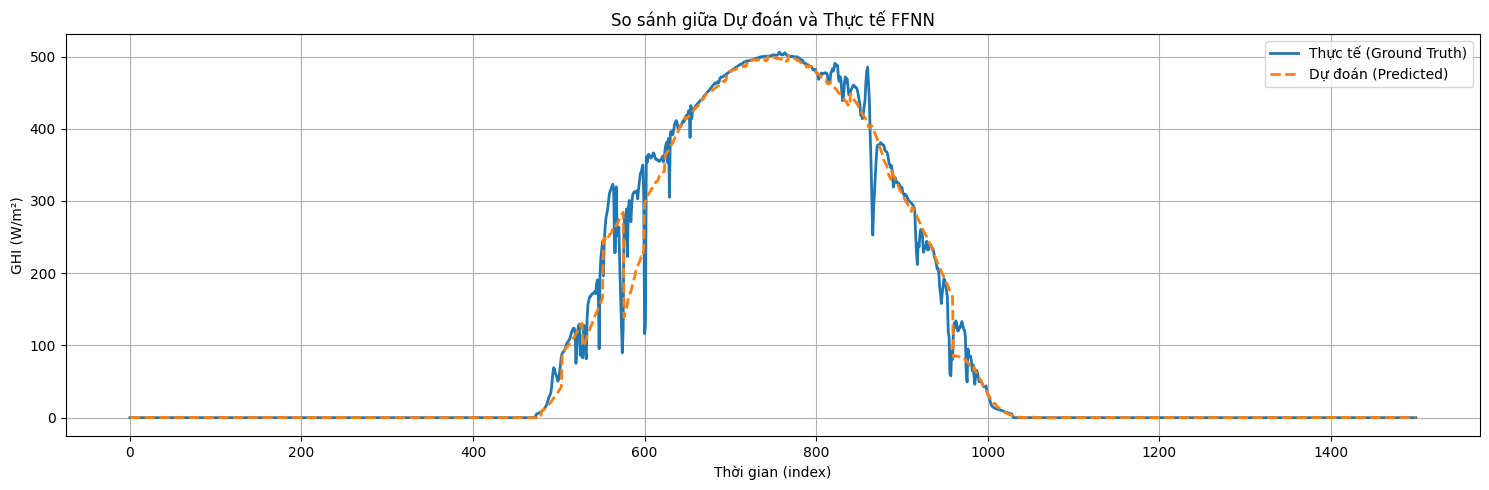

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(all_targets[:1500], label='Thực tế (Ground Truth)', linewidth=2)
plt.plot(all_scores[:1500], label='Dự đoán (Predicted)', linewidth=2, linestyle='--')

plt.title('So sánh giữa Dự đoán và Thực tế FFNN')
plt.xlabel('Thời gian (index)')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()